# Detector de distanciamiento social

Este proyecto tiene como fin detectar en video a las personas que no respetan la distancia mínima de 2 metros entre personas, medida de seguridad establecida para detener el avance de la COVID-19, así como mostrar una vista desde arriba de las personas (también llamada bird-eye view). 

Video demostración: https://www.youtube.com/watch?v=pm3YnYfA7as

## Preparaciones

In [1]:
# !wget https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi
# !wget https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-output-HOGHeads.top

### Importando la librería local que implementa el detector de distanciamiento social

In [2]:
from detector import *
from random import seed
seed(5)

### Definiendo algunas constantes y una función auxiliar

In [3]:
RED = (0, 0, 255)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)

def imshow_bgr(bgr_img):
    rgb_img = bgr_img[:,:,::-1]
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_img)
    plt.axis('off')

### Mostrando el primer cuadro del video

Tamaño de la imagen original: 1920x1080


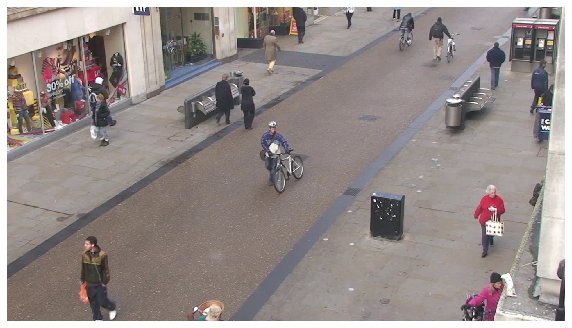

In [4]:
cap = cv2.VideoCapture('./files/TownCentreXVID.avi')
grabbed, frame = cap.read()

print(f'Tamaño de la imagen original: {frame.shape[1]}x{frame.shape[0]}')
imshow_bgr(frame)

Se prefiere trabajar con una imagen de la mitad del tamaño de la original

In [5]:
frame = cv2.resize(frame, dsize=(960, 540), interpolation=cv2.INTER_CUBIC)
print(f'Nuevo tamaño de la imagen: {frame.shape[1]}x{frame.shape[0]}')

Nuevo tamaño de la imagen: 960x540


### Leyendo las posiciones de los transeuntes

Puesto que el tamaño de la imagen fue reducido por un factor de dos, es necesario hacer lo mismo con las coordenadas dadas en el archivo csv.

In [6]:
cols = ['id', 'frame', 'head_valid', 'body_valid',
        'head_left', 'head_top', 'head_right', 'head_bottom',
        'body_left', 'body_top', 'body_right', 'body_bottom']

df = pd.read_csv('TownCentre-groundtruth.top', header=None, names=cols)
df = df.drop(['head_valid', 'body_valid'], axis=1)
df.iloc[:, -8:] = 0.5 * df.iloc[:, -8:]
df = df.astype(int)
df

,id,frame,head_left,head_top,head_right,head_bottom,body_left,body_top,body_right,body_bottom
0,0,0,135,397,154,417,117,385,185,550
1,1,0,154,151,165,163,142,145,185,246
2,2,0,153,120,164,131,143,115,182,208
3,3,0,369,115,379,126,359,110,393,204
4,4,0,407,123,417,134,396,117,430,213
...,...,...,...,...,...,...,...,...,...,...
71455,226,4500,255,121,265,132,245,115,281,209
71456,227,4500,798,261,812,277,777,253,826,385
71457,228,4500,586,267,601,283,572,259,615,393
71458,229,4500,328,142,339,154,317,137,354,237


## Hallando la matriz de transformación

### Mostrando los puntos de referencia

En azul, se muestra el rectángulo cuyas esquinas se tomaron como referencia para hallar la matriz de transformación. También se muestra el bounding box de cada persona en la imagen.

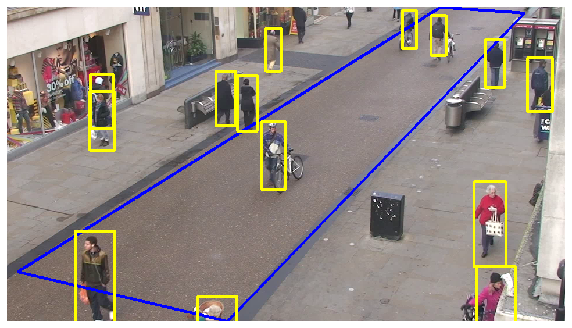

In [7]:
copy = frame.copy()

corners = np.float32([[745, 0], [890, 10], [379, 540], [18, 455]])
corners_ = corners.reshape((-1, 1, 2)).astype('int32')
cv2.polylines(copy, [corners_], isClosed=True, color=BLUE, thickness=3)

frame_df = df[df.frame == 0]

for _, row in frame_df.iterrows():
    top_left = (row.body_left, row.body_top)
    bot_right = (row.body_right, row.body_bottom)
    cv2.rectangle(copy, top_left, bot_right, color=YELLOW, thickness=3)

imshow_bgr(copy)

### Hallando la matriz de transformación

El arreglo ``targets`` define a qué coordenadas en la vista bird-eye view son mapeadas los cuatro puntos de referencia definidos anteriormente. Para encontrar este arreglo se midió en Google Maps que la calle mide aproximadamente 20 metros de largo y 15 metros de ancho (5 metros son de pista), y se utilizó esta información para encontrar el mapeo de los puntos de referencia a una imagen de 371x528, las medidas de la imagen que contiene la vista bird-eye view de las personas.

In [8]:
top_left = np.float32([127, 0])  # Bird-eye view de la esquina superior izquiera
targets = top_left + np.float32([[0, 0], [117, 0], [117, 528], [0, 528]])
matrix = cv2.getPerspectiveTransform(corners, targets)

print('Matriz de transformación:')
print(matrix)

Matriz de transformación:
[[ 7.44571240e-01  1.70429784e+00 -4.29113372e+02]
 [-2.04195558e-01  2.96083560e+00  1.52125691e+02]
 [-1.48792346e-05  4.02835406e-03  1.00000000e+00]]


## Mostrando la transformación en perspectiva

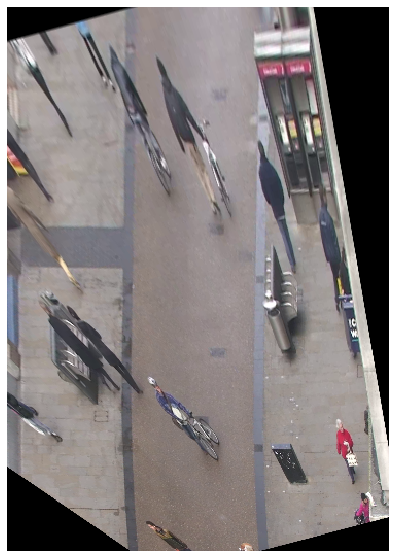

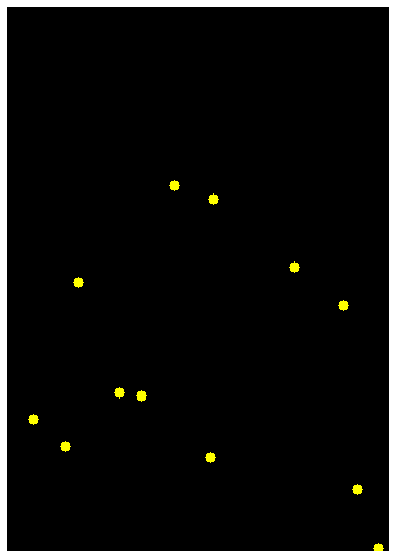

In [9]:
# Se define el canvas sobre el cuál se mostrará
# la vista bird-eye view
w, h = 371, 528
canvas = np.zeros((h, w, 3), dtype='uint8')

# La posición de una persona se define por las coordenadas (x, y)
# del punto medio del segmento inferior de su bounding box
people_positions = []

# Se almacena la posición de cada persona del frame en la lista
# people_positons
for _, person in frame_df.iterrows():
    x = (person.body_left + person.body_right) // 2
    y = person.body_bottom
    people_positions.append([x, y])

# Se usa una transformación en perspectiva con la matriz hallada
# anteriormente para calcular la posición en la vista bird-eye
# de cada persona
people_positions = np.float32([people_positions])
bird_view_pos = cv2.perspectiveTransform(people_positions, matrix, (w, h))
bird_view_pos = np.squeeze(bird_view_pos).astype('int32')

# Se dibuja un círculo en cada posición de las personas en la vista
# bird-eye
for position in bird_view_pos:
    cv2.circle(canvas, tuple(position), 5, YELLOW, -1)


# Se aplica la misma transformación a la imagen original, para fines
# ilustrativos
warped = cv2.warpPerspective(frame, matrix, (w, h))

# Mostrando las imágenes resultantes
imshow_bgr(warped)
imshow_bgr(canvas)

## Probando el detector de distanciamiento social

La librería utils cuenta con las clases necesarias para esta labor. En el archivo utils.py se encuentra la documentación de cada clase. El siguiente código está adaptado del script main.py (que se encuentra en este mismo repositorio).

### Analizando el video

In [10]:
# Initialize the utility classes
frames = FramesContainer()
persons = PersonsContainer()
calculator = Calculator(corners, targets, (w, h))
painter = Painter()

# Get the iterator with the data of each frame
frames_data = get_frames_data()

# Initialize the video stream
stream = FileVideoStream('TownCentreXVID.avi')

# Start the stream
nframe = 0
stream.start()

# Get the initial time and save it
timestamp = time()
start = timestamp

# Loop over frames from the video stream
while stream.running():
    # If there is no more information left, exit the loop
    try:
        frame_info = next(frames_data)
    except:
        break

    # Grab the current frame
    picture = stream.read()

    # Make the current frame object
    frame = Frame(nframe)

    # For every person in the frame
    for person_info in frame_info:
        # Get the person's information
        person_id, _, left, top, right, bot = person_info
        # Create the person object if appearing for first time
        if person_id not in persons:
            person = Person(person_id)
            # Add the new person object to the container
            persons.append(person)
        else:
            # Else, fetch the person from the persons container
            person = persons[person_id]
        # Calculate the center, position and bounding box of the person
        center, position, rectangle = calculator.process(left, top, right, bot)
        # Add the calculated information to the person object
        person.set_info(center, position, rectangle)
        # Add the current frame to the person object, and vice versa
        person.add_frame(nframe)
        frame.add_person(person)

    # Calculate the bird view for every person in the frame
    # and update their bird_view attribute
    bird_views = calculator.get_bird_views(frame.positions)
    frame.update_persons_birdviews(bird_views)

    # Create the canvas over which the bird view points are to
    # be painted
    canvas = np.zeros((h, w, 3), dtype='uint8')

    # For every person in the frame, paint their bounding box
    # and bird view. Initially, it is asumed that the person in safe.
    for person in frame.persons:
        painter.paint_bbox(picture, person.rectangle, 'safe')
        painter.paint_birdview(canvas, person.bird_view, 'safe')

    # Get the pairs of persons that are close to each other
    at_risk_pairs = calculator.get_at_risk_pairs(frame)

    # For every pair found, paint thei bounding box, bird view
    # connect their centers in the camera view and their positions
    # in the bird eye view. It is no longer asumed that the persons are safe.
    for p1, p2 in at_risk_pairs:
        painter.paint_bbox(picture, p1.rectangle, 'at_risk')
        painter.paint_bbox(picture, p2.rectangle, 'at_risk')
        painter.paint_birdview(canvas, p1.bird_view, 'at_risk')
        painter.paint_birdview(canvas, p2.bird_view, 'at_risk')
        painter.paint_connect(picture, p1.center, p2.center, 'at_risk')
        painter.paint_connect(canvas, p1.bird_view, p2.bird_view, 'at_risk')
        # Update the pair info
        calculator.update_pair_info(frame, picture, p1, p2)

    # Append the current frame to the frames container, and check
    # if it is the worst frame seen so far, as in the frame with
    # the largest number of persons exposed.
    frames.append(frame)
    frames.check_if_worst(frame, picture, canvas)

    timestamp = time()
    nframe += 1

# Show the duration of the displayed video
print(f'Analysis took {timestamp-start:.2f} seconds')

Analysis took 44.75 seconds


In [11]:
print('Número de frames analizados:', len(frames))

Número de frames analizados: 4500


In [12]:
print('Número de personas en el video:', len(persons))

Número de personas en el video: 230


### Mostrando las personas en riesgo y la vista bird-eye del frame con mayor número de personas expuestas

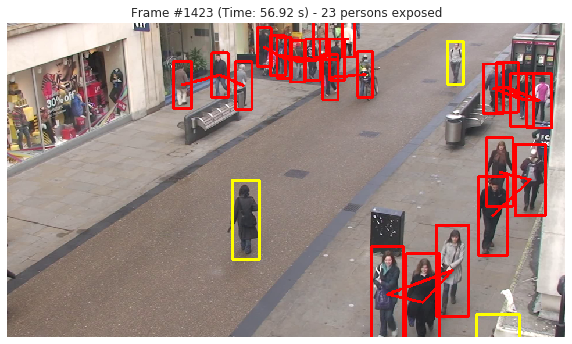

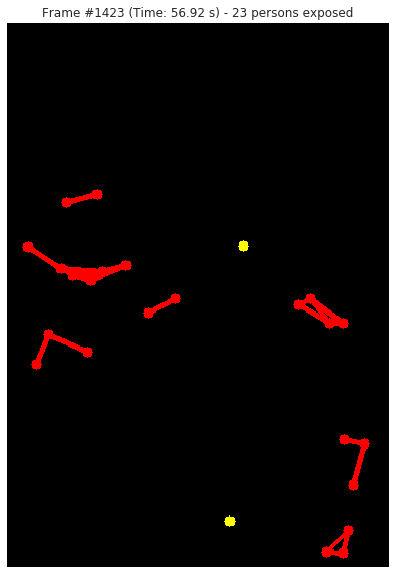

In [13]:
plt.figure(figsize=(10, 10))
frames.show_worst_frame()

plt.figure(figsize=(10, 10))
frames.show_worst_birdview()

Se observa que para este instante casi todas las personas están cerca unas de otras. En total, se tienen 23 personas expuestas al contagio, el máximo número de personas expuestas en un instante del video.

## Extras

### Mostrando información sobre algún cuadro aleatorio del video

In [14]:
frame = frames.random_frame()
print(f'Frame a analizar: frame #{frame.number}')

Frame a analizar: frame #2092


In [15]:
print('Personas que aparecen en el frame')
print('-'*33)
frame.persons

Personas que aparecen en el frame
---------------------------------


{Person 100: 'at_risk',
 Person 101: 'safe',
 Person 102: 'at_risk',
 Person 103: 'at_risk',
 Person 104: 'at_risk',
 Person 105: 'at_risk',
 Person 108: 'safe',
 Person 112: 'safe',
 Person 113: 'at_risk',
 Person 114: 'safe',
 Person 118: 'safe',
 Person 119: 'safe',
 Person 120: 'safe',
 Person 121: 'at_risk',
 Person 123: 'at_risk'}

In [16]:
print(f'Total de personas en el frame: {frame.num_persons}')

Total de personas en el frame: 15


In [17]:
print('Personas respetando el distanciamiento social')
print('-'*45)
print(frame.safe_persons)
print(f'Total: {frame.num_safe}')

Personas respetando el distanciamiento social
---------------------------------------------
[Person 101, Person 108, Person 112, Person 114, Person 118, Person 119, Person 120]
Total: 7


In [18]:
print('Personas que no están respetando el distanciamiento social')
print('-'*58)
print(frame.at_risk_persons)
print(f'Total: {frame.num_at_risk}')

Personas que no están respetando el distanciamiento social
----------------------------------------------------------
[Person 100, Person 102, Person 103, Person 104, Person 105, Person 113, Person 121, Person 123]
Total: 8


Porcentaje de personas seguras y en riesgo en el frame
------------------------------------------------------


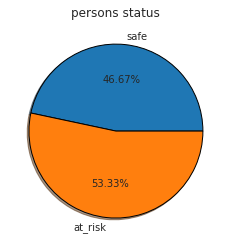

In [19]:
print('Porcentaje de personas seguras y en riesgo en el frame')
print('-'*54)
frame.pieplot()

Se observa que el 53% de las personas del frame están en riesgo.

In [20]:
print('Pares de personas que se encuentran cerca una de la otra')
print('-'*56)
calculator.get_at_risk_pairs(frame)

Pares de personas que se encuentran cerca una de la otra
--------------------------------------------------------


[(Person 100, Person 102),
 (Person 100, Person 103),
 (Person 100, Person 108),
 (Person 103, Person 108),
 (Person 105, Person 118),
 (Person 105, Person 119),
 (Person 113, Person 121),
 (Person 118, Person 119),
 (Person 120, Person 123)]

### Visualizando información general de todos los frames del video

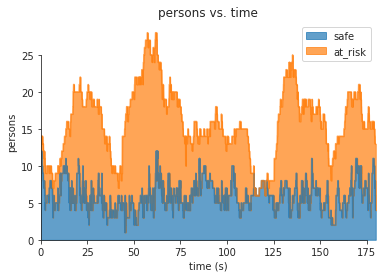

In [21]:
frames.stackplot()

Se observa que la mayor parte del tiempo el número de personas que no respetan el distanciamiento es mayor que las que sí lo hacen.

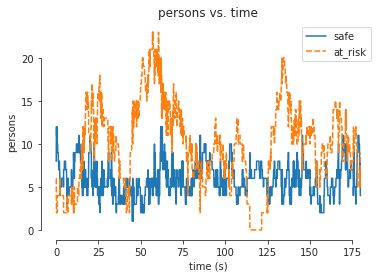

In [22]:
# Los mismos valores que en la gráfica anterior, pero
# mostrados como dos curvas separadas.
frames.lineplot()

En el gráfico circular se aprecia mejor la relación entre las personas que están seguras y las que no

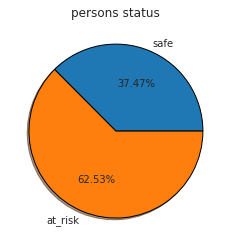

In [23]:
frames.pieplot()

El 63% de las personas que aparecen en el video no respetan el distanciamiento social. Toda la información anterior se resume en la siguiente tabla.

In [24]:
frames.status_df()

,safe,at_risk
time,,
0.00,8,6
0.04,8,6
0.08,10,4
0.12,10,4
0.16,12,2
...,...,...
179.80,4,9
179.84,4,9
179.88,4,9


### Visualizando información general de todas las personas del video

Mostrando las 10 personas más expuestas de acuerdo a la cantidad de personas con las que estuvieron cerca

In [25]:
top10_others = persons.most_exposed(by='others', n=10)

print('Persona\t\tEstuvo cerca de')
print('-------\t\t---------------')
for person in top10_others:
    print(f'id {person.id}\t\t{person.num_encounters} personas')

Persona		Estuvo cerca de
-------		---------------
id 161		16 personas
id 58		15 personas
id 68		15 personas
id 75		14 personas
id 177		14 personas
id 55		13 personas
id 70		13 personas
id 178		12 personas
id 190		12 personas
id 73		11 personas


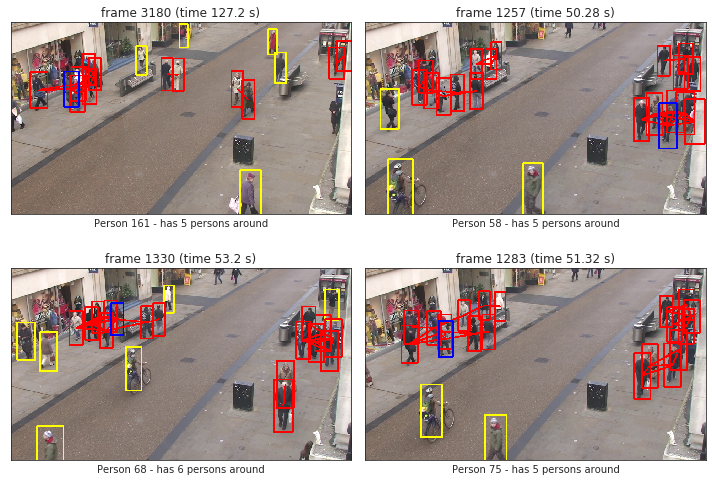

In [26]:
plt.figure(figsize=(10, 7))
persons.show_exposed(painter, by='others')

Mostrando las 10 personas más expuestas de acuerdo a la cantidad de tiempo en que estuvieron cerca de otras personas

In [27]:
top10_time = persons.most_exposed(by='time', n=10)

print('Persona\t\tExpuesto por')
print('-------\t\t------------')
for person in top10_time:
    print(f'id {person.id}\t\t{person.time_exposed} segundos')

Persona		Expuesto por
-------		------------
id 58		27.68 segundos
id 55		27.56 segundos
id 196		22.12 segundos
id 33		21.04 segundos
id 190		20.68 segundos
id 199		20.52 segundos
id 35		19.96 segundos
id 134		19.92 segundos
id 135		19.92 segundos
id 28		19.72 segundos


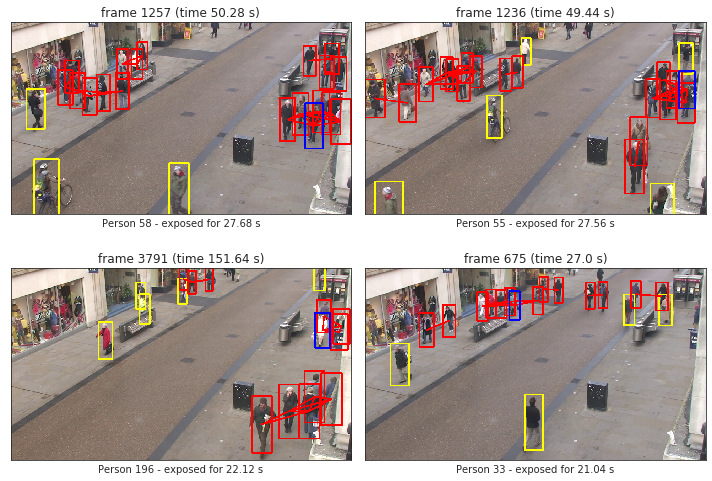

In [28]:
plt.figure(figsize=(10, 7))
persons.show_exposed(painter, by='time')

Podría esperarse que el tiempo de exposición es mayor mientras se haya estado expuesto a más personas. Para corroborarlo, se construye la siguiente gráfica.

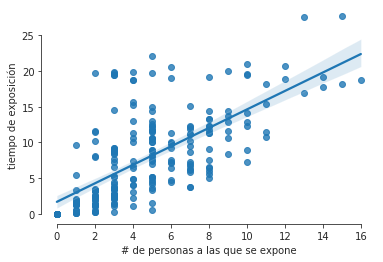

In [29]:
encounters = [person.num_encounters for person in persons]
times = [person.time_exposed for person in persons]

sns.regplot(encounters, times)
plt.xlabel('# de personas a las que se expone')
plt.ylabel('tiempo de exposición')
sns.despine(trim=True)

La regresión lineal muestra que, en general, al aumentar el número de personas a las que alguien se expone, también aumenta su tiempo total de exposición a otras personas. Sin embargo, se ven puntos en los que el número de personas a las que se expone es pequeño, pero el tiempo de exposición es grande. Estos puntos corresponden a las personas que pasan acompañadas.

**Diagramas de caja para detectar patrones de comportamiento atípicos**

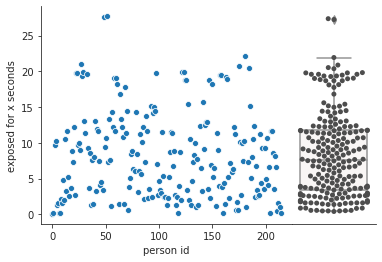

In [30]:
persons.dataplot(by='time', ignore_safe=True)

Se observa que el 75% de las personas tienen un tiempo de exposicón menor a 12 segundos aproximadamente. Además, se encuentran dos puntos con tiempo de exposición atípico. Estos puntos corresponden a las personas de id 55 y 58.

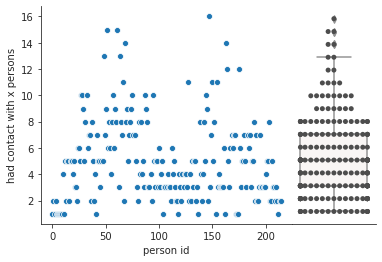

In [31]:
persons.dataplot(by='others', ignore_safe=True)

Se observa que el 75% de las personas tiene contacto con como máximo 7 personas. También se encuentra que 7 personas tienen comportamiento atípico, exponiéndose a más de 13 personas.

**Histogramas**

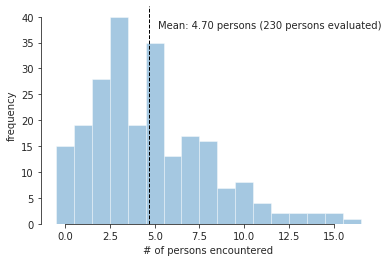

In [32]:
persons.hist(by='others')

En promedio, las personas tienen contacto con otras 4.5 personas.

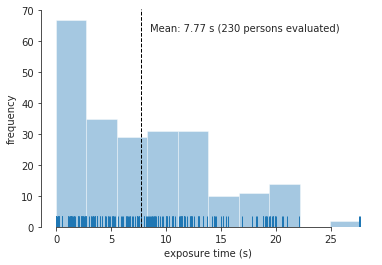

In [33]:
persons.hist(by='time')

En promedio, las personas son expuestas a otras por 7.77 segundos, aunque la mayoría no supera los 2.5 segundos.

Toda la información anterior se puede resumir en la siguiente tabla.

In [34]:
persons.dataframe()

,safe,encounters,time_on_screen,time_exposed,worst_time,max_simult
person,,,,,,
0,True,0,1.48,0.00,0.00,0
1,False,1,2.12,0.08,0.00,1
2,False,2,10.48,0.24,0.00,1
3,False,1,9.68,9.68,0.00,1
4,False,2,10.24,10.24,9.08,2
...,...,...,...,...,...,...
225,False,2,4.40,0.52,175.60,1
226,False,1,4.24,1.64,176.20,1
227,False,2,4.00,1.08,177.16,1


### Visualizando información sobre alguna persona del video

Si se desea, es posible obtener estadísticas de alguna persona específica del video. Se usará la persona 25 del video como ejemplo.

In [35]:
person = persons[25]

print(f'Tiempo de exposición: {person.time_exposed} segundos')
print(f'Tiempo total de aparición en el video: {person.screen_time} segundos')
print(f'Cantidad de personas con las que ha tenido contacto: {person.num_encounters}')

Tiempo de exposición: 7.36 segundos
Tiempo total de aparición en el video: 15.24 segundos
Cantidad de personas con las que ha tenido contacto: 4


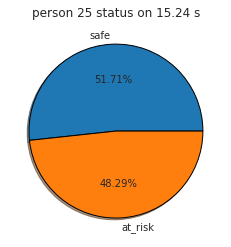

In [36]:
person.pieplot()

El 48% del tiempo la persona no respeta el distanciamiento social.

**Evolución en el tiempo de la cantidad de personas con las que se encuentra**

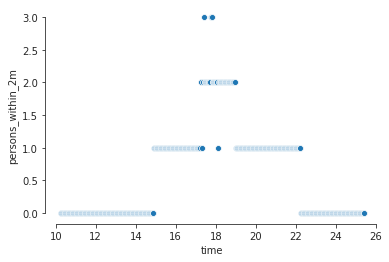

In [37]:
person.scatterplot()

**Mostrando el instante en el que la persona está más rodeada de otras personas**

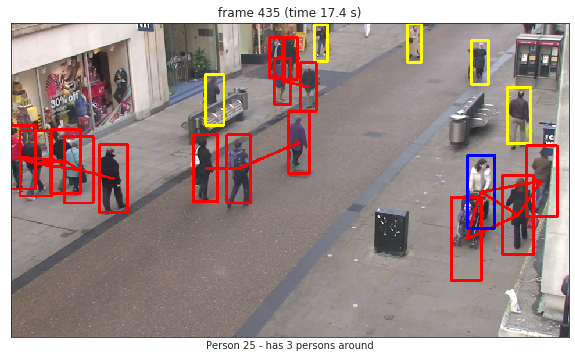

In [38]:
plt.figure(figsize=(10, 7))
person.show_worst_frame(painter)

Toda la información anterior se resume en la siguiente tabla.

In [39]:
person.dataframe()

,time,persons_within_2m
0,10.24,0.0
1,10.28,0.0
2,10.32,0.0
3,10.36,0.0
4,10.40,0.0
...,...,...
376,25.28,0.0
377,25.32,0.0
378,25.36,0.0
379,25.40,0.0


Cabe mencionar que no es necesario procesar todo el video para disponer de estas estadísticas. Es posible detener en cualquier momento el streaming del video, y se guardan las estadísticas calculadas hasta ese momento.

Ver https://www.youtube.com/watch?v=pm3YnYfA7as